In [1]:
import micrograph as mg
import dncnn
import util

import numpy as np
import torch

# Denoising Particle Beam Micrographs with Plug-and-play Methods

## Measurement Simulation

### Forward Model

At each pixel:
* The number of incident ions is $M \sim \mathcal{P}(\lambda)$.
* Each ion produces $X_i \sim \mathcal{P}(\eta)$ SEs; $i = 1, \ldots, M$.
* Conventionally, we measure $Y = \sum_{i = 1}^M X_i$ -- sum of Poisson-distributed number of iid Poisson random variables! We want to recover $\eta$ given $y$.
* With TR, we measure $\{Y^{(i)}\}_{i = 1}^n$, where $Y^{(i)} = \sum_{j = 1}^{M_i} X^{(i)}_j$; $M_i \sim \mathcal{P}(\lambda / n)$ and $X^{(i)}_j \sim \mathcal{P}(\eta)$. We want to recover $\eta$ given $\{y^{(i)}\}_{i = 1}^n$.

**Consequences of forward model**

* If we do TR measurement, then the corresponding conventional measurement is simply $Y = \sum_{i = 1}^n Y^{(i)}$.
* (Conventional) $Y \sim \text{NeymanA}(\eta, \lambda)$.
* (TR) $Y^{(i)} \sim \text{NeymanA}(\eta, \lambda / n)$

**Experimental details**
* (Helium-ion setting) Scale pixel values to $\eta \in [2, 8]$.
* Sampling from the Neyman Type A distribution directly can be slow (see Appendix). To sample measurements efficiently, we use two-step Poisson sampling -- actually mimicking how SEs are generated.

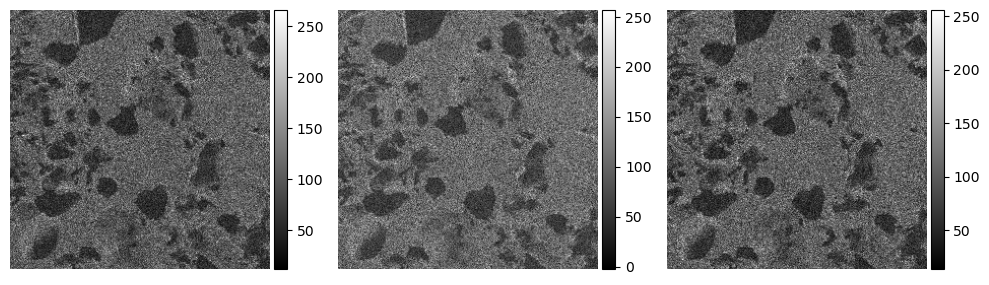

In [2]:
lamb = 20
n = 200
image = util.readImageToEta('data/sponge/val/0.jpg', 2, 8)

yPoipoi = mg.poiPoiSampling(image, lamb)
yGaussian = mg.gaussianSampling(image, lamb)
yTr = mg.poiPoiTrSampling(image, lamb, n)

util.imshow([yPoipoi, yGaussian, np.sum(yTr, axis=0)])

## Plug-and-Play Methods for Denoising Particle Beam Micrographs

In [3]:
# Measurement
lamb = 20
n = 200
etaRange = [2, 8]
dynamicRange = etaRange[1] - etaRange[0]
etaGt = util.readImageToEta('data/sponge/val/0.jpg', minEta=etaRange[0], maxEta=etaRange[1])
yTr, MTr = mg.poiPoiTrSampling(etaGt, lamb, n, retM = True)
yConv = np.sum(yTr, axis=0)
MConv = np.sum(MTr, axis=0)

In [4]:
# Parameters
rho = 2.5
maxIter = 30
tol = 1e-2
gdStepSize = 0.1
etaInit = yConv / MConv

# For DnCNN prior
device = torch.device('cpu')
model = dncnn.DnCNN(17)
dncnn.loadCheckpoint('model/std25.ckpt', model)

ADMMApp:   0%|          | 0/30 [00:00<?, ?it/s]

MSE = 0.11840527960021216
RMSE = 0.3441006823594108
PSNR = 24.82931433092222
SNR = 22.97576155839448
SSIM = 0.7275877894968428


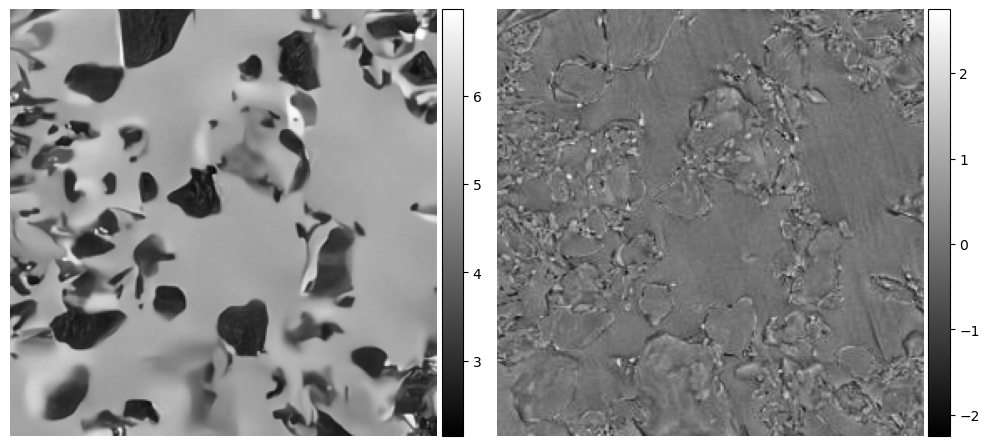

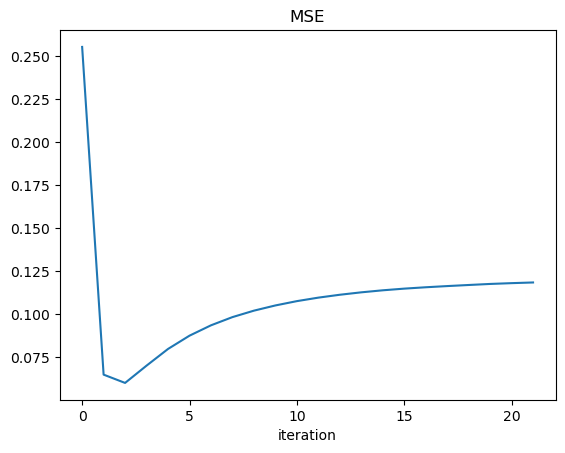

In [5]:
# Gaussian-DnCNN ADMM
fidProx = mg.GaussApproxFidProx(yTr, lamb)
priorProx = mg.DnCNNPriorProx(model, device=device, mu=1.25, imRange=etaRange, denRange=[0, 1])
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)

ADMMApp:   0%|          | 0/30 [00:00<?, ?it/s]

MSE = 0.04911093554396834
RMSE = 0.2216098723973468
PSNR = 28.6512429341815
SNR = 26.836723432296374
SSIM = 0.8455301280215064


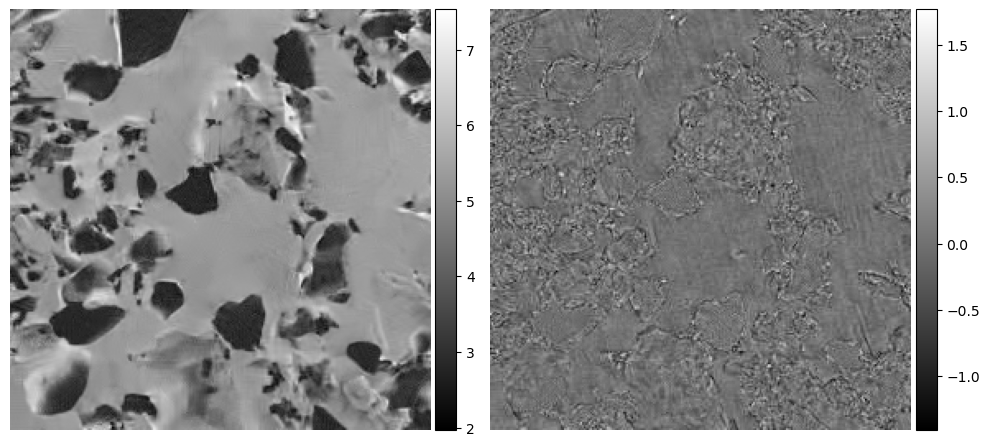

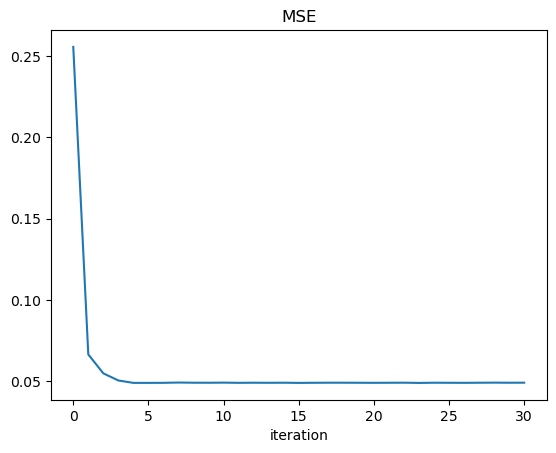

In [6]:
# Oracle-BM3D ADMM
fidProx = mg.OracleFidProx(yTr, MConv)
priorProx = mg.Bm3dPriorProx(0.72)
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)

ADMMApp:   0%|          | 0/30 [00:00<?, ?it/s]

MSE = 0.14333017199023348
RMSE = 0.37858971458590035
PSNR = 23.999648787608848
SNR = 22.67083499460285
SSIM = 0.8051564976639521


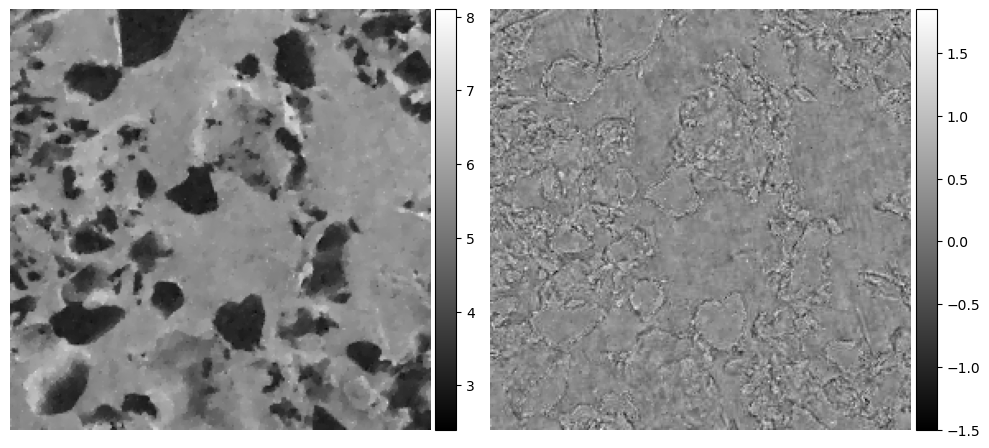

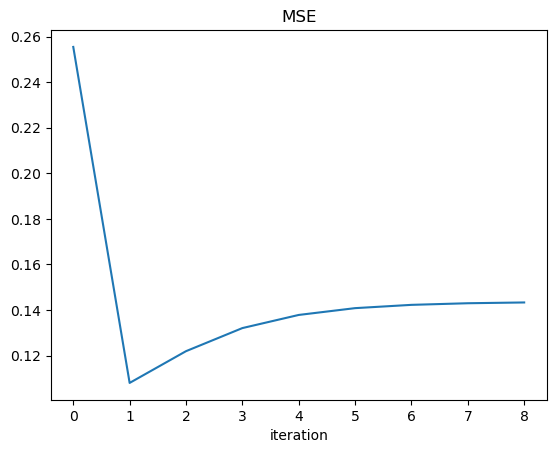

In [7]:
# QM-TV ADMM
fidProx = mg.QMFidProx(yTr)
priorProx = mg.TVPriorProx(1.2)
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)

ADMMApp:   0%|          | 0/30 [00:00<?, ?it/s]

MSE = 0.11020821369850248
RMSE = 0.3319762245982421
PSNR = 25.140885375491262
SNR = 23.769068558155098
SSIM = 0.8403111913900971


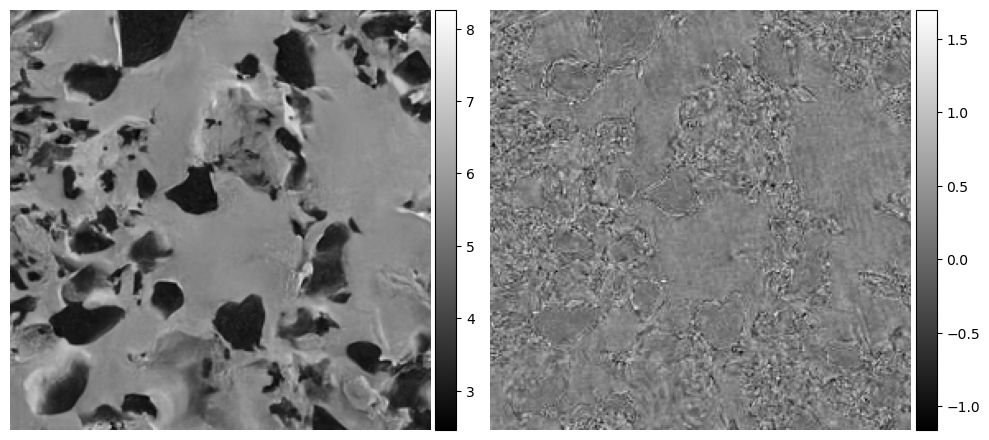

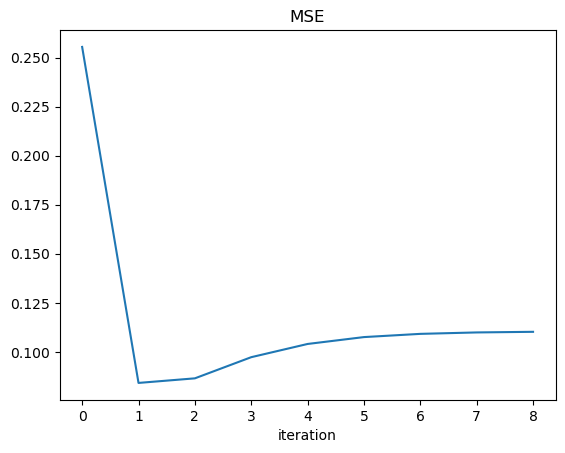

In [8]:
# LQM-DnCNN ADMM
fidProx = mg.LQMApproxFidProx(yTr)
priorProx = mg.DnCNNPriorProx(model, device=device, mu=0.75, imRange=etaRange, denRange=[0, 1])
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)

PGMApp:   0%|          | 0/30 [00:00<?, ?it/s]

MSE = 0.06461266565535566
RMSE = 0.25419021549885756
PSNR = 27.459848421364867
SNR = 25.646824965386
SSIM = 0.8021561550022677


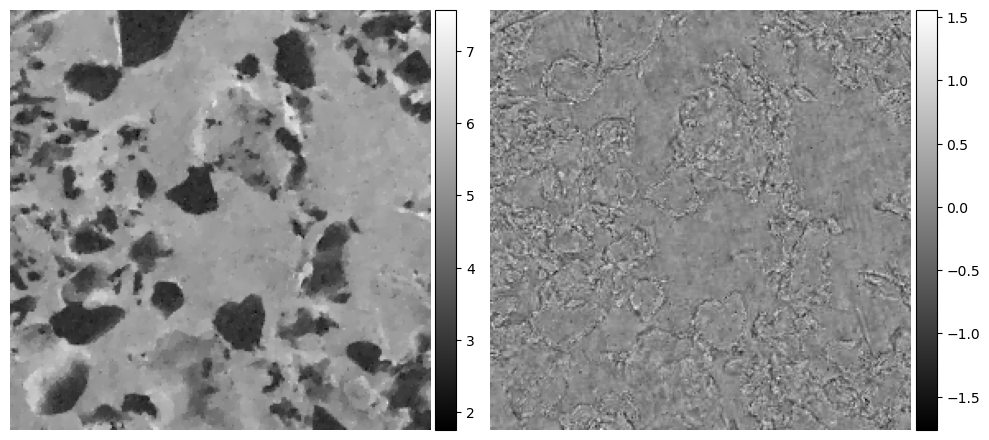

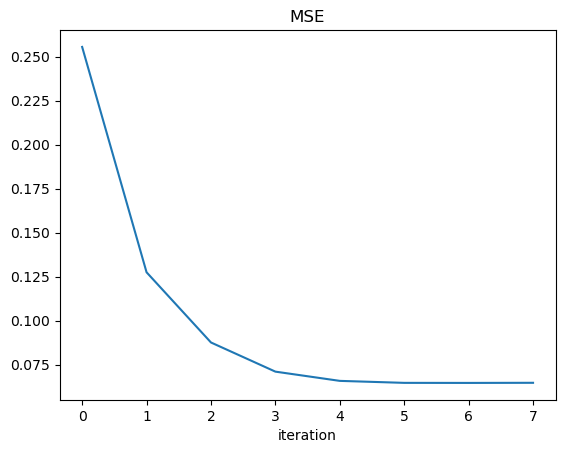

In [9]:
# TRML-TV FISTA
fidGrad = mg.TRApproxFidGrad(yTr, lamb)
priorProx = mg.TVPriorProx(0.24)
app = mg.PGMApp(fidGrad, priorProx, gdStepSize, etaInit, maxIter, fista=True,
                tol=tol, xGt=etaGt)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)